In [1]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, NLocal, PauliTwoDesign
# from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD # chemistry simulation ansatzes, for example the UCCSD ansatz prepares a state where tuning the parameters turns excitations on and off
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
import numpy as np 
from numpy import sqrt, pi, linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.result import marginal_counts
from IPython.display import display, clear_output
from qiskit import Aer, transpile, assemble
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_bloch_vector, plot_state_qsphere
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, PauliOp
from qiskit_optimization import QuadraticProgram
from qiskit.providers.aer.noise import NoiseModel
from qiskit import IBMQ, execute
IBMQ.load_account()
provider = IBMQ.get_provider(group='open', project='main')

In [2]:
# Prepare State Circuit (n Qubit)-cu3 only
def PrepareState(parameter,q = 2):
    qg = QuantumRegister(q,'q')
    qc = QuantumCircuit(qg)
    
    qc.u3(parameter[0],parameter[1],-parameter[1],q-1)
    qc.barrier(range(q))
    theta = 2
    
    for i in range(q):
        for j in range(q-i-1):
            qc.cu3(parameter[theta],parameter[theta+1],-parameter[theta+1],i+j+1,i)
            qc.x(i+j+1)
            qc.cu3(parameter[theta+2],parameter[theta+3],-parameter[theta+3],i+j+1,i)
            qc.x(i+j+1)
            theta +=4
            qc.barrier(range(q))
    return qc

In [3]:
# Prepare general State Circuit (n Qubit)-Multicontrol qubit
def PrepareState_Gen(parameter,q = 2):
    # Multi control U3 gate
    def MCUGate(p1,p2,ctrlqubit):
        ctrl = QuantumCircuit(1, name='U3')
        # U3 decompose
        ctrl.rz(p2,0)
        ctrl.rx(-np.pi/2,0)
        ctrl.rz(p1,0)
        ctrl.rx(np.pi/2,0)
        ctrl.rz(-p2,0)
        # U3 decompose
        ctrl = ctrl.to_gate().control(ctrlqubit)
        return ctrl
    # State's bit string converter
    def Bitstring(inter,leng):
        result = []
        while inter >= 2:
            d = inter % 2
            inter = inter//2
            result.append(d)
        result.append(inter)
        for i in range(leng-len(result)):
            result.append(0)
        return result

    qg = QuantumRegister(q,'q')
    qc = QuantumCircuit(qg)
    qc.u(parameter[0],parameter[1],-parameter[1],q-1)
    qc.barrier(range(q))
    theta = 2
    # Apply multi-control qubit gate
    for i in range(q-1):
        listctrl = [ i+n+1 for n in range(q-i-1)]
        listctrl.append(i)
        for j in range(2**(q-i-1)):
            bitstring = Bitstring(j,q-i-1)
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1)
            qc.append(MCUGate(parameter[theta],parameter[theta+1],q-i-1),listctrl) 
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1) 
            theta +=2
        qc.barrier(range(q))
    return qc

In [119]:
def Expectation_Exact(gate=None,q1=None,q2=None,circ=None):
    qc = QuantumCircuit(circ.num_qubits,circ.num_qubits)
    qc.append(circ,[i for i in range(circ.num_qubits)])
    if gate == "Z": # Measure two Pauli Z 
        P1 = Statevector(qc).probabilities([q1]) # P(i)
        P2 = Statevector(qc).probabilities([q2]) # P(j)
        P00 = Statevector(qc).probabilities([q1,q2]) # P(i,j)
        firesult=(4*P00[0])-1-(2*(P1[0])-1)-(2*(P2[0])-1) # =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "1Z":
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    elif gate == "X": # Measure one Pauli X
        qc.h(q1) # Apply H gate to apply X basic measurement
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    elif gate == "YY": # Measure two Pauli Y
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.sdg(q2) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q2) # Apply H gate to apply X basic measurement
        P1 = Statevector(qc).probabilities([q1]) # P(i)
        P2 = Statevector(qc).probabilities([q2]) # P(j)
        P00 = Statevector(qc).probabilities([q1,q2]) # P(i,j)
        firesult=(4*P00[0])-1-(2*(P1[0])-1)-(2*(P2[0])-1) # =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "Y": # Measure one Pauli Y
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    return firesult

def Expectation_backend(gate=None,q1=None,q2=None,circ=None,realbackend=Aer.get_backend('qasm_simulator')):
    qc = QuantumCircuit(circ.num_qubits,circ.num_qubits)
    qc.append(circ,[i for i in range(circ.num_qubits)])
    
    # backend = Aer.get_backend('qasm_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    backend = realbackend
    shot=20000
    
    # Get string of state
    qubit = qc.num_qubits
    bitq1 = '' # Get string of |...01...> state
    bitq2 = '' # Get string of |...10...> state
    bit0 = ''  # Get string of |...00...> state
    for i in range(qubit):
        bit0 += '0'
        if i == q1:
            bitq1 += '1'
            bitq2 += '0'
        elif i == q2:
            bitq2 += '1'
            bitq1 += '0'
        else:
            bitq1 += '0'
            bitq2 += '0'
    bit0 = bit0[::-1]
    bitq1 = bitq1[::-1]
    bitq2 = bitq2[::-1]
    
    if gate == "Z":
        qc.measure([q1,q2],[q1,q2])
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        for output in [bit0,bitq1,bitq2]:
            if output in result:
                result[output]/=shot
            else:
                result[output] = 0
        firesult=4*(result[bit0])-1-(2*(result[bit0]+result[bitq1])-1)-(2*(result[bit0]+result[bitq2])-1)# =(4P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "X":
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.measure(q1,q1)  
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        if bit0 in result:
            result[bit0]/=shot
        else:
            result[bit0] = 0
        firesult=(2*(result[bit0])-1)# =(2P(i=0)-1)
    return firesult

In [133]:
Cir = QuantumCircuit(3)
Expectation_Exact("1Z",0,circ=Cir)

1.0

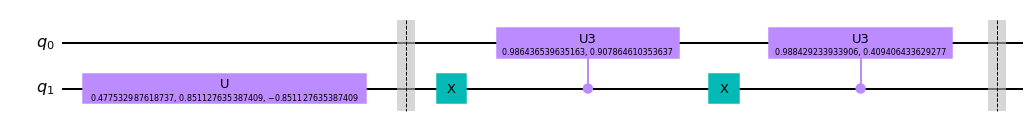

In [5]:
backend = Aer.get_backend('qasm_simulator')
seed = 132     #set random seed
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed, shots=20000)
q = 2

parameters = ParameterVector('θ', 2**(q+1)-2)
param_dict = {parameter: np.random.random() for parameter in parameters}

parameter=[np.random.random() for i in range(2**(q+1)-2)]

State = PrepareState_Gen(parameters,q)
State = State.assign_parameters(parameters = param_dict)
State.draw(output='mpl')

# VQE qiskit code

# ZZ = PauliOp(Pauli(label='ZZ'))
# XI = PauliOp(Pauli(label='XI'))
# IX = PauliOp(Pauli(label='IX'))
# op = ZZ+0.5*(XI+IX) 

# optimizer = COBYLA(maxiter=1000)
# vqe = VQE(State,optimizer=optimizer,quantum_instance=quantum_instance)
# result = vqe.compute_minimum_eigenvalue(op)
# print(result.optimal_value)

In [6]:
def Ising_Hamilton(q,h):
    Ising_Hamilton = 0
    for i in range(q):
        Zterm  = 1
        Xterm  = 1
        for j in range(q-1):
            if j == i:
                Zterm = Zterm^Z^Z
                Xterm  = Xterm^X^I
            elif i == (q-1) and j == (i-1):
                Xterm = Xterm^I^X
                Zterm = 0
            else:
                Zterm = Zterm^I
                Xterm = Xterm^I
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    return Ising_Hamilton

In [7]:
def vqe_exact(qc, parameter, q,h, file=None):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_Exact("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_Exact("Z",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        if file == None:
            continue
        else:
            file.write(f'Parameter: {parameter} \n ')
            file.write(f'Result: {result} \n ')
            file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton 

In [8]:
def vqe_exact1(qc, parameter, q,h, file=None):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_Exact("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_Exact("Z",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        # file.write(f'Parameter: {parameter} \n ')
        # file.write(f'Result: {result} \n ')
        # file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

In [9]:
def vqe_backend(qc,parameter, q,h, file=None):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # # qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_backend("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_backend("Z",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        file.write(f'Parameter: {parameter} \n ')
        file.write(f'Result: {result} \n ')
        file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

In [10]:
def vqe_backend_opt(parameter,q,h,meas_map = None,file=None,shots=20000,realbackend = provider.get_backend('ibmq_qasm_simulator')):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    qc = TwoLocal(q, ['ry','rz'], 'cz', 'linear', reps=1)
    qc = qc.assign_parameters(parameter)

    # backend = Aer.get_backend('qasm_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    backend = realbackend
    
    def Qcir(gate=None,p=None,q = q,qc = qc):
        if gate == 'Z':
            cir = QuantumCircuit(q,2)
            cir.append(qc,[i for i in range(q)])
            cir.measure([p,p+1], [0,1])
        elif gate == 'X':
            cir = QuantumCircuit(q,1)
            cir.append(qc,[i for i in range(q)])
            cir.h(p)
            cir.measure(p,0)
        cir = transpile(cir, backend=backend,optimization_level=3)
        return cir

    def Check(result,index,shots = shots):
        if index not in result:
            result[index]=0
        return result[index]/shots
        
    Z_cir = [0 for i in range(q-1)]
    X_cir = [0 for i in range(q)]
    for i in range(q):
        X_cir[i] = Qcir('X',i)
        if i < (q-1):
            Z_cir[i] = Qcir('Z',i)
    Hamil_cir = []
    Hamil_cir = Z_cir+X_cir
    
    Assem = assemble(Hamil_cir, backend,meas_map=meas_map,shots=shots)
    job = backend.run(Assem)    
    result = job.result().get_counts()

    Ising_Hamilton = 0
    for i in range(q):
        Xterm = 2*Check(result[q+i-1],'0')-1
        if i < (q-1):
            Zterm = 4*(Check(result[i],'00'))-1-(2*(Check(result[i],'00')+Check(result[i],'01'))-1)-(2*(Check(result[i],'00')+Check(result[i],'10'))-1)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    
    file.write(f'\n Job ID: {job.job_id()} \n ')
    file.write(f'Parameter: {parameter} \n ')
    file.write(f'Result: {result} \n ')
    file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

In [11]:
def vqe_exact_opt(parameter,q,h,file=None,realbackend = Aer.get_backend('statevector_simulator')):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)

    # backend = Aer.get_backend('statevector_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    backend = realbackend

    def Res(result,p,gate):
        value = 0
        if gate == 'X':
            for index in result:
                if index[::-1][p:(p+1)] == '0':
                    value += result[index]
        elif gate == 'Z':
            for index in result:
                if index[::-1][p:(p+2)] == '00' or index[::-1][p:(p+2)] == '11':
                    value += result[index]
        return (2*value -1)
        
        
    Z_cir =  QuantumCircuit(q)
    Z_cir.append(qc,[i for i in range(q)])
    X_cir =  QuantumCircuit(q)
    X_cir.append(qc,[i for i in range(q)])
    X_cir.h([i for i in range(q)])
    Hamil_cir = [Z_cir,X_cir]
    
    job = execute(Hamil_cir, backend) 
    result = job.result().get_counts()

    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Res(result[1],i,'X')
        if i < (q-1):
            Zterm = Res(result[0],i,'Z')
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

    # file.write(f'\n Job ID: {job.job_id()} \n ')
    # file.write(f'Parameter: {parameter} \n ')
    # file.write(f'Result: {result} \n ')
    # file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

**Parameter-shift rules (local simulation)**

In [14]:
def PSR_exact(q,h,qc,parameters, l_rate=0.2, ite = 100):
    Deriva = [[0] for i in range(qc[0].num_parameters)]
    Upd_para = [[0] for i in range(qc[0].num_parameters)]
    vqe = []
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]

        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
            
        for i in range(len(parameters)):
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[i] = np.pi/2

            if i % 2 == 0:
                Dvqe[i] = (1/2*(vqe_exact(qc[0], [fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0],[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
            else:
                # For general ansatz
                if qc[1] == 'gen':
                    Dvqe[i] = (1/sqrt(2)*(vqe_exact(qc[0], [fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0], [fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
                # For Pauli rotation gate ansatz
                else:
                    Dvqe[i] = (1/2*(vqe_exact(qc[0], [fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0], [fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
            
            parameters[i]-=l_rate*Dvqe[i]
            Upd_para[i].append(parameter[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_exact(qc[0], parameters,q,h))
    return vqe_exact(qc[0], parameters,q,h), Deriva, Upd_para, vqe

**Classical Gradient Descend - Finite Difference**

In [ ]:
def FiniteDiff_exact(q,h,qc,parameters, epsilon = 1e-3 ,l_rate=0.2, ite = 100):
    Deriva = [[0] for i in range(qc[0].num_parameters)]
    Upd_para = [[0] for i in range(qc[0].num_parameters)]
    vqe = []
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            finite_diff = [0 for i in range(len(parameters))]
            finite_diff [i] = epsilon

            Dvqe[i] = (1/(2*epsilon)*(vqe_exact(qc[0], [fix_parameters[i] + finite_diff[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0],[fix_parameters[i] - finite_diff[i] for i in range(len(fix_parameters))],q,h)))
        
            parameters[i]-=l_rate*Dvqe[i]
            Upd_para[i].append(parameter[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_exact(qc[0], parameters,q,h))
    return vqe_exact(qc[0], parameters,q,h), Deriva, Upd_para, vqe

**PSR method optimization for backend real device running**

In [51]:
q = 2
h = 0
tol = 1e-3
l_rate = 0.3
numberofiteration = 50
shots = 20000
backend = Aer.get_backend('qasm_simulator')
meas_map = None

qc = RealAmplitudes(q, entanglement='linear', reps=1)
parameters = [np.random.uniform(0,2*np.pi) for i in range(qc.num_parameters)]
# parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(2**(q+1)-2)]

def Qcir(gate=None,p=None,q = q,qc = qc):
    if gate == 'Z':
        cir = QuantumCircuit(q,2)
        cir.append(qc,[i for i in range(q)])
        cir.measure([p,p+1], [0,1])
    elif gate == 'X':
        cir = QuantumCircuit(q,1)
        cir.append(qc,[i for i in range(q)])
        cir.h(p)
        cir.measure(p,0)
    cir = transpile(cir, backend=backend,optimization_level=3)
    return cir

def Check(result,index,shots = shots):
    if index not in result:
        result[index]=0
    return result[index]/shots
    
for j in range(numberofiteration):
    Dvqe = [0 for i in range(len(parameters))]
    Hamil_cir = []
    for i in range(len(parameters)):
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = np.pi/2
        nqc = []
        nqc.append(qc.assign_parameters([parameters[i] + PSR_parameter[i] for i in range(len(parameters))]))
        nqc.append(qc.assign_parameters([parameters[i] - PSR_parameter[i] for i in range(len(parameters))]))
        for k in range(2):
            Z_cir = [0 for i in range(q-1)]
            X_cir = [0 for i in range(q)]
            for i in range(q):
                X_cir[i] = Qcir('X',i,q,nqc[k])
                if i < (q-1):
                    Z_cir[i] = Qcir('Z',i,q,nqc[k])
            Hamil_cir += Z_cir+X_cir
    job = execute(Hamil_cir, backend,meas_map=meas_map,shots=shots) 
    result = job.result().get_counts()
    for i in range(len(parameters)):
        Ising_Hamilton = [0,0]
        for n in range(2):
            for k in range(q):
                Xterm = 2*Check(result[i*(4*q-2)+n*(2*q-1)+q+k-1],'0')-1
                if k < (q-1):
                    Zterm = 4*(Check(result[i*(4*q-2)+n*(2*q-1)+k],'00'))-1-(2*(Check(result[i*(4*q-2)+n*(2*q-1)+k],'00')+Check(result[i*(4*q-2)+n*(2*q-1)+k],'01'))-1)-(2*(Check(result[i*(4*q-2)+n*(2*q-1)+k],'00')+Check(result[i*(4*q-2)+n*(2*q-1)+k],'10'))-1)
                elif k == (q-1):
                    Zterm = 0
                Ising_Hamilton[n] = Ising_Hamilton[n] + Zterm + h*Xterm
        Dvqe[i] = 1/2*(Ising_Hamilton[0]-Ising_Hamilton[1])
        parameters[i]-=l_rate*Dvqe[i]
print(vqe_exact1(parameters,q,h))

-0.9999947247680966


**PSR method optimization for backend exact simulator running**

In [50]:
q = 2
h = 0
tol = 1e-3
l_rate = 0.3
numberofiteration = 50
shots = 20000
backend = Aer.get_backend('statevector_simulator')
meas_map = None

qc = RealAmplitudes(q, entanglement='linear', reps=1)
parameters = [np.random.uniform(0,2*np.pi) for i in range(qc.num_parameters)]
# parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(2**(q+1)-2)]

def Res(result,p,gate):
    value = 0
    if gate == 'X':
        for index in result:
            if index[::-1][p:(p+1)] == '0':
                value += result[index]
    elif gate == 'Z':
        for index in result:
            if index[::-1][p:(p+2)] == '00' or index[::-1][p:(p+2)] == '11':
                value += result[index]
    return (2*value -1)
    
for j in range(numberofiteration):
    Dvqe = [0 for i in range(len(parameters))]
    Hamil_cir = []
    for i in range(len(parameters)):
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = np.pi/2
        nqc = []
        nqc.append(qc.assign_parameters([parameters[i] + PSR_parameter[i] for i in range(len(parameters))]))
        nqc.append(qc.assign_parameters([parameters[i] - PSR_parameter[i] for i in range(len(parameters))]))
        for k in range(2):
            Z_cir =  QuantumCircuit(q)
            Z_cir.append(nqc[k],[i for i in range(q)])
            X_cir =  QuantumCircuit(q)
            X_cir.append(nqc[k],[i for i in range(q)])
            X_cir.h([i for i in range(q)])
            Hamil_cir.append(Z_cir)
            Hamil_cir.append(X_cir)
    
    job = execute(Hamil_cir, backend,meas_map=meas_map) 
    result = job.result().get_counts()
    
    for i in range(len(parameters)):
        Ising_Hamilton = [0,0]
        for n in range(2):
            for k in range(q):
                Xterm = Res(result[4*i+2*n+1],k,'X')
                if k < (q-1):
                    Zterm = Res(result[4*i+2*n],k,'Z')
                elif k == (q-1):
                    Zterm = 0
                Ising_Hamilton[n] = Ising_Hamilton[n] + Zterm + h*Xterm
        Dvqe[i] = 1/2*(Ising_Hamilton[0]-Ising_Hamilton[1])
        parameters[i]-=l_rate*Dvqe[i]
print(vqe_exact1(parameters,q,h))

-1.0


**Quantum Natural Gradient Descent - Block-diagonal Approximation**

In [ ]:
q = 6
# h = 1
l_rate = 0.2
numberofiteration = 200

RealAmp = {'qubit': q , 'entanglement': 'linear','reps':1}
real = RealAmplitudes(RealAmp['qubit'], entanglement=RealAmp['entanglement'], reps=RealAmp['reps'])
num_para = real.num_parameters

itera0 = []
value0 = []

# Create sub-circuit
qc = [0 for i in range(int(num_para/q))]
for k in range(int(num_para/q)):
        qc[k] = RealAmplitudes(RealAmp['qubit'], entanglement=RealAmp['entanglement'], reps=k,skip_final_rotation_layer=True)

for y in range(10):
    h = 2*y/10
    parameters = [0.5 for i in range(num_para)]
    itera0.append(h)
    for l in range(numberofiteration):
        # itera0.append(l)
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]

        # Metric tensor
        g = np.zeros([num_para,num_para])
        sqc = [0 for i in range(int(num_para/q))]
        for m in range(num_para):
            k = m/q
            if k.is_integer():
                k = int(k)
                sqc[k] =  qc[k].assign_parameters(parameters[:q*k])
                for i in range(q):
                    for j in range(q):
                        if j == i: 
                            g[i+q*k,j+q*k] = 1 - Expectation_Exact('Y',j,circ=sqc[k])**2
                        else:
                            g[i+q*k,j+q*k]= Expectation_Exact('YY',i,j,circ= sqc[k])-Expectation_Exact('Y',i,circ= sqc[k])*Expectation_Exact('Y',j,circ = sqc[k])

        # Paramter-shift rules
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[m] = np.pi/2
            Dvqe[m] = (1/2*(vqe_exact1([fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact1([fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
        
        # Pseudo-inverse
        g = linalg.pinv(g)
        # Update papramter
        for i in range(num_para):
            for j in range(num_para):
                parameters[i]-=l_rate*g[i,j]*Dvqe[j]
    value0.append(vqe_exact1(parameters,q,h))

**Classical check**

In [44]:
q = 2
h = 0.3
# Haminlton matrix
Hal =  Operator(Ising_Hamilton(q,h))
# Classical solver
w,v = np.linalg.eig(Hal)
minimum=w[0]
min_spot=0
for i in range(1,2**q):
    if w[i]<minimum:
        min_spot=i
        minimum=w[i]                   
groundstate = v[:,min_spot]
# print("Ground State")
# print(groundstate)
print("Ground Energy")
print(minimum)


Ground Energy
(-1.1661903789690578+0j)


**Comparison**

*Ansatz* 
1) `General Ansatz` 
2) `EfficientSU2 Ansatz`
3) `ReamAmplitude Ansatz` 

*Method* 
1) `Cobyla` 
2) `PRS` 
3) `Fin_Diff` 
4) `QNG` 

*Backend* (Not necessary for small qubit)
1) `QASM`
2) `Statevertor`



Classical results

In [12]:
# Number of qubit
q = 3

cvalue = []
hvalue = []


for i in [0,0.3,0.6,0.9,1.2,1.5,1.8]:
    h = i
    hvalue.append(h)
    op = Ising_Hamilton(q,h) 

    # Classical solver
    w,v = np.linalg.eig(Operator(op))
    minimum=w[0]
    min_spot=0
    for i in range(1,2**q):
        if w[i]<minimum:
            min_spot=i
            minimum=w[i]                   
    groundstate = v[:,min_spot]
    cvalue.append(minimum)

General Ansatz

In [13]:
# Initialization
epsilon = 1e-3
l_rate = 0.2
numberofiteration = 150
optimizer = COBYLA(maxiter=1000)
backend = Aer.get_backend('statevector_simulator')
parameter = ParameterVector('θ', 2**(q+1)-2)
gen_ans = PrepareState_Gen(parameter,q)

gen_cob = []
gen_prs_va = []
gen_fd_va = []

gen_prs_pa = [[0] for i in range(gen_ans.num_parameters)]
gen_fd_pa= [[0] for i in range(gen_ans.num_parameters)]

gen_cob_counts = [] 
gen_cob_va = []
gen_cob_pa = []
gen_cob_devi = []
def callback(eval_count, parameters, mean, std):  
    gen_cob_counts.append(eval_count)
    gen_cob_va.append(mean)
    gen_cob_pa.append(parameters)
    gen_cob_devi.append(std)

In [14]:
for i in [0,0.3,0.6,0.9,1.2,1.5,1.8]:
    h = i

    # Ising Hamilton matrix operator
    op = Ising_Hamilton(q,h) 
    

    # VQE qiskit solver, General ansatz
    parameters = [0.5 for i in range(gen_ans.num_parameters)]
    vqer = VQE(gen_ans,optimizer=optimizer,quantum_instance=backend, initial_point=parameters,callback=callback)
    result = vqer.compute_minimum_eigenvalue(op)
    gen_cob.append(result.optimal_value)

    
    # Parameter-shift rules, General ansatz
    parameters = [0.5 for i in range(gen_ans.num_parameters)]
    for j in range(numberofiteration):
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[i] = np.pi/2
            if i % 2 == 0:
                Dvqe[i] = (1/2*(vqe_exact(gen_ans,[fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(gen_ans,[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
            else:
                Dvqe[i] = (1/sqrt(2)*(vqe_exact(gen_ans,[fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(gen_ans,[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
            
            parameters[i]-=l_rate*Dvqe[i]

            gen_prs_pa[i].append(parameters[i])
        gen_prs_va.append(vqe_exact(gen_ans,parameters,q,h))


    # Finite Difference, General ansatz
    parameters = [0.5 for i in range(gen_ans.num_parameters)]
    for j in range(numberofiteration):
        Dvqe = [pi/2 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            finite_parameter = [0 for i in range(len(parameters))]
            finite_parameter[i] = epsilon
            
            Dvqe[i] = (1/(2*epsilon)*(vqe_exact(gen_ans,[fix_parameters[i] + finite_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(gen_ans,[fix_parameters[i] - finite_parameter[i] for i in range(len(fix_parameters))],q,h)))
            
            parameters[i]-=l_rate*Dvqe[i]

            gen_fd_pa[i].append(parameters[i])
        gen_fd_va.append(vqe_exact(gen_ans,parameters,q,h))

EfficentSU2 Ansatz

In [177]:
# Initialization
epsilon = 1e-3
l_rate = 0.2
numberofiteration = 150
optimizer = COBYLA(maxiter=1000)
backend = Aer.get_backend('statevector_simulator')
su2Ans = {'qubit': q , 'entanglement': 'linear','reps':1 }
su2_ans = EfficientSU2(su2Ans['qubit'] ,entanglement=su2Ans['entanglement'], reps=su2Ans['reps'])
su2_num_para = su2_ans.num_parameters

su2_cob = []
su2_prs_va = []
su2_qng_va= []

su2_prs_pa = [[0] for i in range(gen_ans.num_parameters)]
su2_qng_pa = [[0] for i in range(gen_ans.num_parameters)]

su2_cob_counts = [] 
su2_cob_va = []
su2_cob_pa = []
su2_cob_devi = []
def callback(eval_count, parameters, mean, std):  
    su2_cob_counts.append(eval_count)
    su2_cob_va.append(mean)
    su2_cob_pa.append(parameters)
    su2_cob_devi.append(std)

# Create sub-circuit for EfficientSU2 ansatz (perculiar for each type of ansatz)
qc = [0 for i in range(int(su2_num_para/q))]
for k in range(int(su2_num_para/(q))):
    if k % 2 ==0:              
        qc[k] = EfficientSU2(su2Ans['qubit'], entanglement=su2Ans['entanglement'], reps=int(k/2),skip_final_rotation_layer=True)
    else:
        qc[k] = EfficientSU2(su2Ans['qubit'], entanglement=su2Ans['entanglement'], reps=int((k-1)/2),skip_final_rotation_layer=False)

In [178]:
for i in [0,0.3,0.6,0.9,1.2,1.5,1.8]:
    h = i

    # Ising Hamilton matrix operator
    op = Ising_Hamilton(q,h) 

    # VQE qiskit solver, EfficientSU2 ansatz
    parameters = [0.5 for i in range(su2_ans.num_parameters)]
    vqer = VQE(su2_ans,optimizer=optimizer,quantum_instance=backend, initial_point=parameters,callback=callback)
    result = vqer.compute_minimum_eigenvalue(op)
    su2_cob.append(result.optimal_value)

    
    # Parameter-shift rules, EfficientSU2 ansatz
    parameters = [0.5 for i in range(su2_ans.num_parameters)]
    for j in range(numberofiteration):
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[i] = np.pi/2
            Dvqe[i] = (1/2*(vqe_exact(su2_ans,[fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(su2_ans,[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
            parameters[i]-=l_rate*Dvqe[i]
            su2_prs_pa[i].append(parameters[i])
        su2_prs_va.append(vqe_exact(su2_ans,parameters,q,h))


    # Quantum Natural Gradient Descent, EfficientSU2 ansatz
    parameters = [0.5 for i in range(su2_ans.num_parameters)]
    for l in range(numberofiteration): 
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]

        # Metric tensor
        g = np.zeros([su2_num_para,su2_num_para])
        sqc = [0 for i in range(int(su2_num_para/(q)))]
        for m in range(su2_num_para):
            k = m/(q)
            if k.is_integer():
                k = int(k)
                # For Ry rotation gate
                if k % 2 == 0:
                    sqc[k] =  qc[k].assign_parameters(parameters[:q*k])
                    for i in range(q):
                        for j in range(q):
                            if j == i:
                                g[i+q*k,j+q*k] = 1 - Expectation_Exact('Y',j,circ=sqc[k])**2
                            else:
                                g[i+q*k,j+q*k]= Expectation_Exact('YY',i,j,circ= sqc[k])-Expectation_Exact('Y',i,circ= sqc[k])*Expectation_Exact('Y',j,circ = sqc[k])
                # For Rz rotation gate
                else:
                    sqc[k] =  qc[k].assign_parameters(parameters[:q*(k+1)])
                    for i in range(q):
                        for j in range(q):
                            if j == i:
                                g[i+q*k,j+q*k] = 1 - Expectation_Exact('1Z',j,circ=sqc[k])**2
                            else:
                                g[i+q*k,j+q*k]= Expectation_Exact('Z',i,j,circ= sqc[k])-Expectation_Exact('1Z',i,circ= sqc[k])*Expectation_Exact('1Z',j,circ = sqc[k])

        # Paramter-shift rules
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[m] = np.pi/2
            Dvqe[m] = (1/2*(vqe_exact(su2_ans,[fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(su2_ans,[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
        
        # Pseudo-inverse
        g = linalg.pinv(g)
        # Update papramter
        for i in range(su2_num_para):
            for j in range(su2_num_para):
                parameters[i]-=l_rate*g[i,j]*Dvqe[j]
            su2_qng_pa[i].append(parameters[i])
        su2_qng_va.append(vqe_exact(su2_ans,parameters,q,h))

RealAmplitude Ansatz

In [179]:
# Initialization
epsilon = 1e-3
l_rate = 0.2
numberofiteration = 150
optimizer = COBYLA(maxiter=1000)
backend = Aer.get_backend('statevector_simulator')
real_ans = RealAmplitudes(q, reps=1, entanglement='linear')
real_num_para = real_ans.num_parameters
real_Nrotblock_1q = int(real_num_para/((1+1)*q)) # k+1 = 1+1 with k is the reps

real_cob = []
real_prs_va = []
real_qng_va= []

real_prs_pa = [[0] for i in range(gen_ans.num_parameters)]
real_qng_pa = [[0] for i in range(gen_ans.num_parameters)]

real_cob_counts = [] 
real_cob_va = []
real_cob_pa = []
real_cob_devi = []
def callback(eval_count, parameters, mean, std):  
    real_cob_counts.append(eval_count)
    real_cob_va.append(mean)
    real_cob_pa.append(parameters)
    real_cob_devi.append(std)

# Create sub-circuit for calculating QNG
qc = [0 for i in range(int(real_num_para/(real_Nrotblock_1q*q)))]
for k in range(int(real_num_para/(real_Nrotblock_1q*q))):
        qc[k] = RealAmplitudes(q, entanglement='linear', reps=k,skip_final_rotation_layer=True)

In [180]:
for i in [0,0.3,0.6,0.9,1.2,1.5,1.8]:
    h = i
    
    # Ising Hamilton matrix operator
    op = Ising_Hamilton(q,h) 
    
    # VQE qiskit solver, RealAmplitude ansatz
    parameters = [0.5 for i in range(real_ans.num_parameters)]
    vqer = VQE(real_ans,optimizer=optimizer,quantum_instance=backend, initial_point=parameters,callback=callback)
    result = vqer.compute_minimum_eigenvalue(op)
    real_cob.append(result.optimal_value)

    
    # Parameter-shift rules, RealAmplitude ansatz
    parameters = [0.5 for i in range(real_ans.num_parameters)]
    for j in range(numberofiteration):
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[i] = np.pi/2
            Dvqe[i] = (1/2*(vqe_exact(real_ans,[fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(real_ans,[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
            parameters[i]-=l_rate*Dvqe[i]
            real_prs_pa[i].append(parameter[i])
        real_prs_va.append(vqe_exact(real_ans,parameters,q,h))


    # Quantum Natural Gradient Descent, RealAmplitude ansatz
    parameters = [0.5 for i in range(real_ans.num_parameters)]
    for l in range(numberofiteration): 
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]

        # Metric tensor
        g = np.zeros([real_num_para,real_num_para])
        sqc = [0 for i in range(int(real_num_para/(real_Nrotblock_1q*q)))]
        for m in range(real_num_para):
            k = m/q
            if k.is_integer():
                k = int(k)
                sqc[k] =  qc[k].assign_parameters(parameters[:real_Nrotblock_1q*q*k])
                for i in range(real_Nrotblock_1q*q):
                    for j in range(real_Nrotblock_1q*q):
                        if j == i: 
                            g[i+real_Nrotblock_1q*q*k,j+real_Nrotblock_1q*q*k] = 1 - Expectation_Exact('Y',j,circ=sqc[k])**2
                        else:
                            g[i+real_Nrotblock_1q*q*k,j+real_Nrotblock_1q*q*k]= Expectation_Exact('YY',i,j,circ= sqc[k])-Expectation_Exact('Y',i,circ= sqc[k])*Expectation_Exact('Y',j,circ = sqc[k])

        # Paramter-shift rules
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[m] = np.pi/2
            Dvqe[m] = (1/2*(vqe_exact(real_ans,[fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(real_ans,[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
        
        # Pseudo-inverse
        g = linalg.pinv(g)
        # Update papramter
        for i in range(real_num_para):
            for j in range(real_num_para):
                parameters[i]-=l_rate*g[i,j]*Dvqe[j]
            real_qng_pa[i].append(parameters[i])
        real_qng_va.append(vqe_exact(real_ans,parameters,q,h))

In [181]:
# Create Ising ground energy array from large energy list
gen_prs = []
gen_fd = []

su2_prs = []
su2_qng = []

real_prs = []
real_qng = []

for i in range(7):
    gen_prs.append(gen_prs_va[(i+1)*150-1])
    gen_fd.append(gen_fd_va[(i+1)*150-1])

    su2_prs.append(su2_prs_va[(i+1)*150-1])
    su2_qng.append(su2_qng_va[(i+1)*150-1])

    real_prs.append(real_prs_va[(i+1)*150-1])
    real_qng.append(real_qng_va[(i+1)*150-1])

In [182]:
# Calculate the discrepancy
for i in range(7):
    gen_cob[i] -= np.real(cvalue[i])
    gen_prs[i] -= np.real(cvalue[i])
    gen_fd[i] -= np.real(cvalue[i])

    su2_cob[i] -= np.real(cvalue[i])
    su2_prs[i] -= np.real(cvalue[i])
    su2_qng[i] -= np.real(cvalue[i])

    real_cob[i] -= np.real(cvalue[i])
    real_prs[i] -= np.real(cvalue[i])
    real_qng[i] -= np.real(cvalue[i])

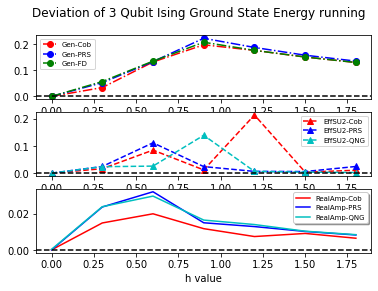

In [183]:
# Accuracy plot

plt.figure()
plt.suptitle('Deviation of 3 Qubit Ising Ground State Energy running')

plt.subplot(311)
plt.plot(hvalue, gen_cob, 'r-.o',label='Gen-Cob')
plt.plot(hvalue, gen_prs, 'b-.o',label='Gen-PRS')
plt.plot(hvalue, gen_fd, 'g-.o',label='Gen-FD')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend(loc='best',fontsize='x-small')
# plt.ylabel('Deviation')

plt.subplot(312)
plt.plot(hvalue, su2_cob, 'r--^',label='EffSU2-Cob')
plt.plot(hvalue, su2_prs, 'b--^',label='EffSU2-PRS')
plt.plot(hvalue, su2_qng, 'c--^',label='EffSU2-QNG')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend(loc='best',fontsize='x-small')
# plt.ylabel('Deviation')

plt.subplot(313)
plt.plot(hvalue, real_cob, 'r-',label='RealAmp-Cob')
plt.plot(hvalue, real_prs, 'b-',label='RealAmp-PRS')
plt.plot(hvalue, real_qng, 'c-',label='RealAmp-QNG')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend(loc='best',fontsize='x-small',fancybox=True, shadow=True)
# plt.ylabel('Deviation')
plt.xlabel('h value')
# plt.plot(hvalue,np.real(cvalue),'r--')

plt.show()

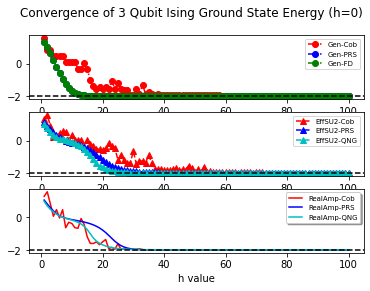

In [188]:
# Convergence plot
a = 0
b = 100

plt.figure()
plt.suptitle('Convergence of 3 Qubit Ising Ground State Energy (h=0)')

plt.subplot(311)
plt.plot(gen_cob_counts[a:b], gen_cob_va[a:b], 'r-.o',label='Gen-Cob')
plt.plot(gen_cob_counts[a:b], gen_prs_va[a:b], 'b-.o',label='Gen-PRS')
plt.plot(gen_cob_counts[a:b], gen_fd_va[a:b], 'g-.o',label='Gen-FD')
plt.axhline(y=-2, color='black', linestyle='--')
plt.legend(loc='best',fontsize='x-small')
# plt.ylabel('Deviation')

plt.subplot(312)
plt.plot(su2_cob_counts[a:b], su2_cob_va[a:b], 'r--^',label='EffSU2-Cob')
plt.plot(su2_cob_counts[a:b], su2_prs_va[a:b], 'b--^',label='EffSU2-PRS')
plt.plot(su2_cob_counts[a:b], su2_qng_va[a:b], 'c--^',label='EffSU2-QNG')
plt.axhline(y=-2, color='black', linestyle='--')
plt.legend(loc='best',fontsize='x-small')
# plt.ylabel('Deviation')

plt.subplot(313)
plt.plot(real_cob_counts[a:b], real_cob_va[a:b], 'r-',label='RealAmp-Cob')
plt.plot(real_cob_counts[a:b], real_prs_va[a:b], 'b-',label='RealAmp-PRS')
plt.plot(real_cob_counts[a:b], real_qng_va[a:b], 'c-',label='RealAmp-QNG')
plt.axhline(y=-2, color='black', linestyle='--')
plt.legend(loc='best',fontsize='x-small',fancybox=True, shadow=True)
# plt.ylabel('Deviation')
plt.xlabel('h value')
# plt.plot(hvalue,np.real(cvalue),'r--')

plt.show()

In [187]:
# Save data
f = open("VQE_Report_Data.txt", "w")
f.write('\n 3 Qubit Ising Ground State \n')
f.write('\n  General Ansatz \n')
f.write('\n   1) Cobyla: \n')
f.write(f'\n      gen_cob: {gen_cob} \n')
f.write(f'\n      gen_cob_counts: {gen_cob_counts} \n')
f.write(f'\n      gen_cob_va: {gen_cob_va} \n')
f.write(f'\n      gen_prs_va: {gen_prs_va} \n')
f.write(f'\n      gen_fd_va: {gen_fd_va} \n')
f.write(f'\n      gen_cob_pa: {gen_cob_pa} \n')
f.write(f'\n      gen_prs_pa: {gen_prs_pa} \n')
f.write(f'\n      gen_fd_pa: {gen_fd_pa} \n')


304343